In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import sqlite3
import pandas as pd
from rubin_sim.scheduler.utils import EuclidOverlapFootprint
from rubin_sim.utils import ra_dec2_hpid, healbin
import os
import glob

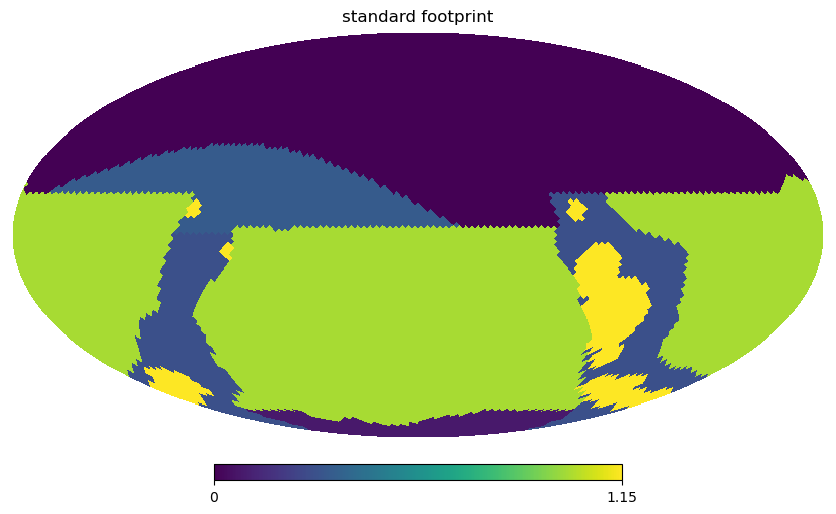

In [2]:
# Let's check what our standard footprint looks like
nside=32
sky = EuclidOverlapFootprint(nside=nside, smc_radius=4, lmc_radius=6)
footprints_hp_array, labels = sky.return_maps()
hp.mollview(footprints_hp_array["r"], title='standard footprint')

In [3]:
# All the observations are passed into the solver, but let's not
# bother looking at the residuals for things like the SCP and Bulge
np.unique(labels)
good_hp = np.where((labels=="LMC_SMC") |  (labels=="dusty_plane") |  
                   (labels=="lowdust") | (labels=="euclid_overlap") | (labels=="virgo"))[0]

In [4]:
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'euclid_overlap', 'lowdust',
       'nes', 'scp', 'virgo'], dtype='<U20')

In [5]:
# Read the stars in
con = sqlite3.connect("msrgb_1e6.sqlite")
stars_df = pd.read_sql("select id,ra,decl,umag,gmag,rmag,imag,zmag,ymag from stars;" , con)
con.close()
# Repackage as numpy array
names = ['id', 'ra', 'decl', 'umag', 'gmag','rmag','imag','zmag','ymag',]
types = [int, float, float, float, float, float, float, float, float]
stars_in = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
for key in names:
    stars_in[key] = stars_df[key].values

In [6]:
def parse_name(infile):
    fn = os.path.basename(infile).replace('.npz', '')
    ack = fn.split('_')
    npatch = int(ack[-1])
    years = float(ack[-2])
    filtername = ack[-3]
    run_name = '_'.join(ack[:-3])
    return npatch,years,filtername,run_name

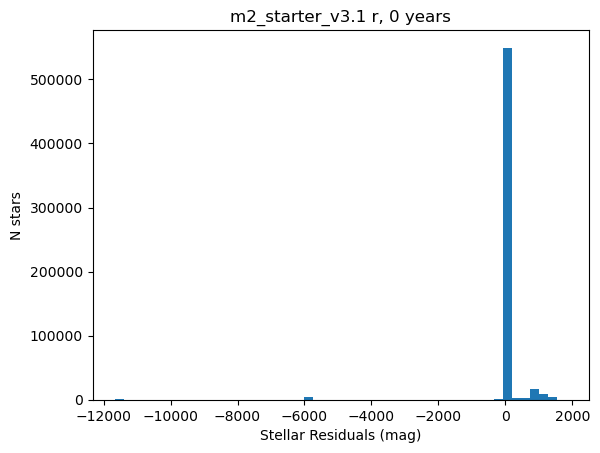

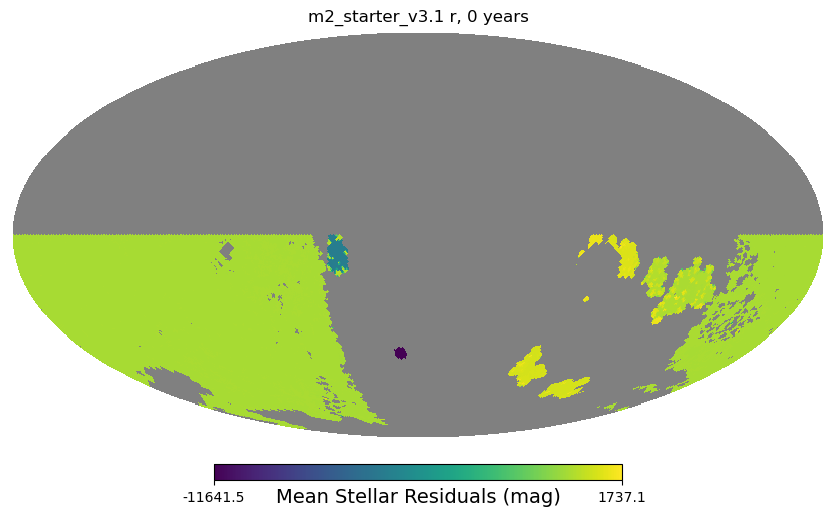

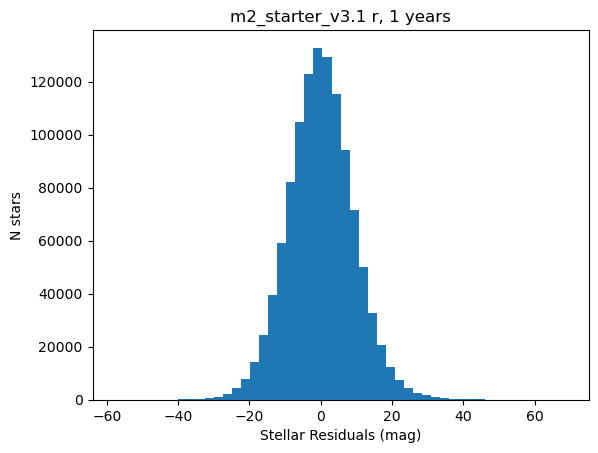

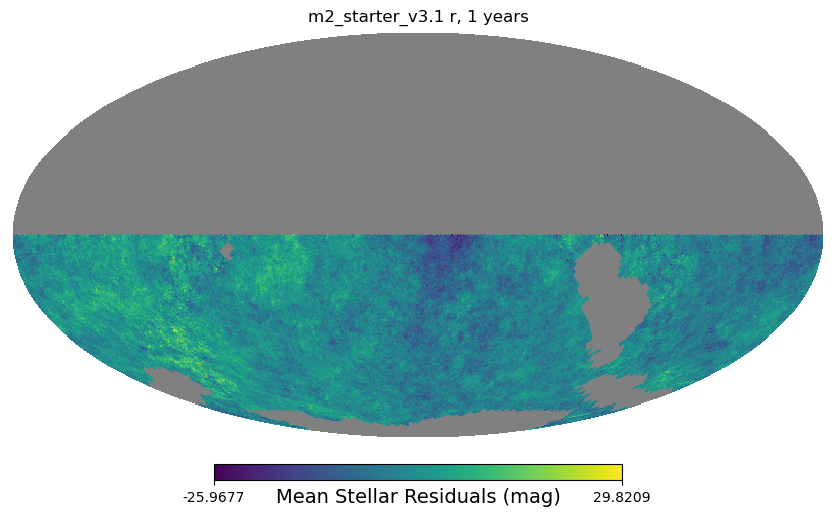

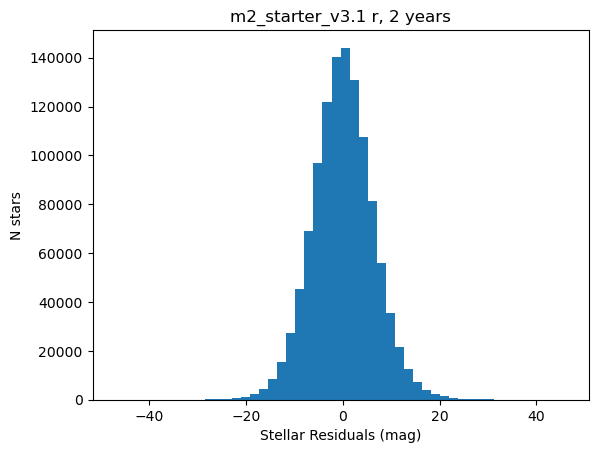

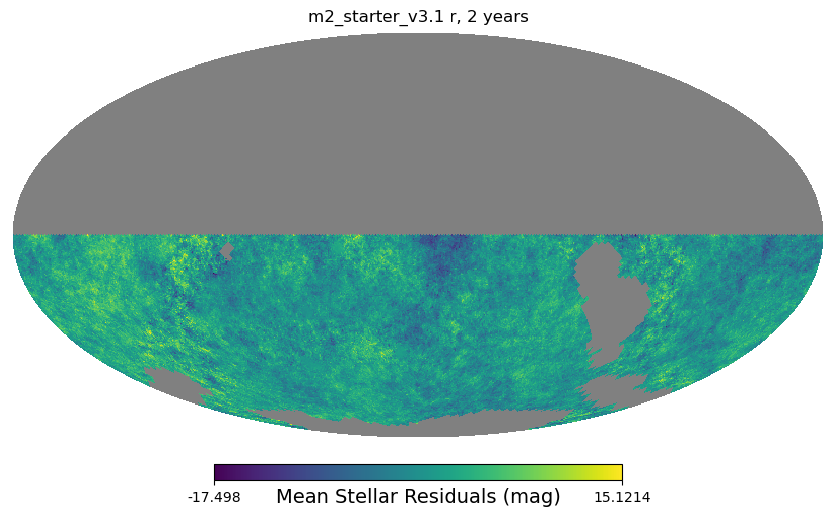

In [7]:
results = []

filenames = glob.glob('*10yrs*.npz')
filenames.sort()

for filename in filenames:
    npatch,years,filtername,run_name = parse_name(filename)
    stars_out = np.load(filename)['fit_stars'].copy()

    resid = stars_in[np.in1d(stars_in['id'], stars_out['id'])]["%smag" % filtername] - stars_out["fit_mag"]
    # Only look at residuals of stars that are in the desired area
    ra = stars_in["ra"][np.in1d(stars_in['id'], stars_out['id'])]
    dec = stars_in["decl"][np.in1d(stars_in['id'], stars_out['id'])]
    stars_hp = ra_dec2_hpid(32, ra, dec)
    resid = resid[np.in1d(stars_hp, good_hp)]
    # remove the floating zeropint, convert to mmag
    resid -= np.median(resid)
    resid *= 1000

    ra = ra[np.in1d(stars_hp, good_hp)]
    dec = dec[np.in1d(stars_hp, good_hp)]

    title = run_name.replace('_10yrs', '') + ' '+filtername + ', %i years' % years

    fig, ax = plt.subplots()
    ax.hist(resid, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Stellar Residuals (mag)')
    ax.set_ylabel('N stars')

    std_iqr = (np.percentile(resid, 75) - np.percentile(resid, 25))/1.35
    results.append([run_name, npatch, years, filtername, std_iqr, np.std(resid)])

    resid_map = healbin(ra, dec, resid, nside=128, reduce_func=np.mean)
    hp.mollview(resid_map,  title=title, unit='Mean Stellar Residuals (mag)')



In [8]:
df = pd.DataFrame(results, columns=['run name', 'npatch', 'years', 'filter', 'IQR std', 'std dev'])

In [9]:
df

,run name,npatch,years,filter,IQR std,std dev
0,m2_starter_v3.1_10yrs,16,0.2,r,20.085055,740.447335
1,m2_starter_v3.1_10yrs,16,1.0,r,8.699547,9.150011
2,m2_starter_v3.1_10yrs,16,2.0,r,5.911144,6.274366
